In [311]:
import functools
from collections import namedtuple
from random import choice
from tqdm.auto import tqdm
import numpy as np
from queue import PriorityQueue
from numpy import array_str
import heapq
import logging

action = namedtuple('Action', ['pos1', 'pos2'])

container_experiment = {}

for n in range(2,5):
    container_experiment[n] = []

In [312]:
def do_action(state: np.ndarray, action: 'Action') -> np.ndarray:
    new_state = state.copy()
    new_state[action.pos1], new_state[action.pos2] = new_state[action.pos2], new_state[action.pos1]
    return new_state

def goal_function( state ,goal ):
    label = np.array_equal(state, goal)
    if(label):
        return True
    else:
        return False
    
def available_actions(state: np.ndarray) -> list['Action']:
    global PUZZLE_DIM
    x, y = [int(_[0]) for _ in np.where(state == 0)]
    actions = list()
    if x > 0:
        actions.append(action((x, y), (x - 1, y)))
    if x < PUZZLE_DIM - 1:
        actions.append(action((x, y), (x + 1, y)))
    if y > 0:
        actions.append(action((x, y), (x, y - 1)))
    if y < PUZZLE_DIM - 1:
        actions.append(action((x, y), (x, y + 1)))
    return actions


In [313]:
def initial_random_state( n ):
    global value_to_coordinates
    PUZZLE_DIM = n
    action = namedtuple('Action', ['pos1', 'pos2'])
    RANDOMIZE_STEPS = 100_000
    state = np.array([i for i in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
    goal = state
    for r in tqdm(range(RANDOMIZE_STEPS), desc='Randomizing'):
        state = do_action(state, choice(available_actions(state)))
    
     
    for i in range(len(goal)):
        for j in range(len(goal)):
            value = goal[i][j]
            value_to_coordinates[value]= (i , j)

    return state , goal


def manhattan_distance(point1, point2):
    return sum(abs(a - b) for a, b in zip(point1, point2))

In [314]:
def manhattan_distance_for_matrix(state):
    global goal , value_to_coordinates, PUZZLE_DIM

    matrix_distance=  np.zeros((PUZZLE_DIM, PUZZLE_DIM))
    for i in range(PUZZLE_DIM):
        for j in range(PUZZLE_DIM):
            coordinate= (i,j)
            value = state[i,j]
            coordinate_goal= value_to_coordinates[value]
            manathan_dist = manhattan_distance(coordinate,coordinate_goal)
            matrix_distance[i,j]= int(manathan_dist)
    return matrix_distance


In [315]:
class CustomPriorityQueue:
    
    def __init__(self, input_function = None):
        self.function = input_function
        self.pq = PriorityQueue()  # The actual PriorityQueue
        ##### USE THE FUNCTION  function
        self.items_set = set()  # Set to track items in the queue
        self.count = 0  # Variable to keep track of the number of elements
    
    def put(self, item, priority):
        if( self.function is None):
            self.pq.put((item, priority))  # Add to the PriorityQueue
        else:       
            value = self.function(item)
            self.pq.put((item, priority+value))
        self.items_set.add(priority)  # Track item in the set
        self.count += 1  # Increment the count when an item is added

    def get(self):
        priority, item = self.pq.get()  # Get from the PriorityQueue
        self.items_set.remove(item)  # Remove from the set
        self.count -= 1  # Increment the count when an item is added
        return item, priority
    
    def contains(self, item):
        return item in self.items_set  # Check if the item exists in the set
    
    def empty(self):
        return self.pq.empty()  # Check if the PriorityQueue is empty
    
    def size(self):
        return self.count  # Return the number of elements in the queue

#### IMPLEMENTATED BUT NOT WORKING

In [316]:
"""    IF I WANT TO RUN fix the function h error on differences = tuple(a - b for a, b in zip(indexes, goal_indexes))
       - Write here what is the scope of A* - which value if important to define the cost
value_to_coordinates = {}
stucked_state = dict()
PUZZLE_DIM = 2
state , goal = initial_random_state(PUZZLE_DIM) # #### modify based the size
name , length_path , length_state = search( state  ,priority_mode= h, name="A* h function")
print(PUZZLE_DIM ,name , length_path , length_state)
container_experiment[PUZZLE_DIM].append([name, length_path, length_state ] )
"""
def h(state):
    global goal , PUZZLE_DIM  , value_to_coordinates , stucked_state 
    #### backtrack - previous cost and state are has been seen 
    #### condition using lexicographic tupla ( matrix postion (true- false ) , distance  ), if i don't have solution 
    #### penalizzare se stato gia visto
    #print(goal)
    #print(state)
    x_state, y_state = [int(_[0]) for _ in np.where(state == 0)]   #### where is point zero - ( x , y ) 

    boolean_matrix = (state == goal)
    total_sum_boolean = np.sum(boolean_matrix)
    boolean_matrix[x_state, y_state] = True
    
    ### manathan distance no on the matrix but on the elements
    distance_matrix = np.abs(state - goal)
    distance_matrix [x_state, y_state] = 0
    total_sum = np.sum(distance_matrix) #### 
    #print(distance_matrix)
    #print(boolean_matrix)

    lista_cost = available_actions(distance_matrix)   #### extract the  position
    list_action = [ x[1]  for x in lista_cost]    
    container = [ ( distance_matrix[position] ,position   ) for position in list_action if boolean_matrix[position]==False  ] ### available action depending the distance matrix
    #print(container) 


    #print("for loop")
    total_sum_tuple=0
    ### total_sum_tuple compute the quality of our movement
    for el in container:
        value = el[0].item()
        indexes = el[1]  
        #print(value , indexes)
        #print(value_to_coordinates)
        goal_indexes = value_to_coordinates[value][0]
        #print(goal_indexes)
        print(indexes)
        print(goal_indexes)
        differences = tuple(a - b for a, b in zip(indexes, goal_indexes))
        total_sum_tuple = sum(abs(x) for x in differences)
        #print(total_sum_tuple)

    final_scalar = total_sum_tuple +  ( boolean_matrix.size  - total_sum_boolean) + ( np.sum(distance_matrix) -np.sum(goal)  ) ### the last difference works in anyway
    try:
        value = stucked_state[array_str(state)]
        if(value==final_scalar):
            final_scalar= final_scalar**2
            stucked_state[array_str(state)] = final_scalar
    except KeyError as k:
        stucked_state[array_str(state) ] = final_scalar
    #### total sum tuple =0, we are stucked

    return final_scalar  ### the last difference works in anyway

In [317]:
def g(state):
    global goal , PUZZLE_DIM  , value_to_coordinates , stucked_state 
    #### backtrack - previous cost and state are has been seen 
    #### condition using lexicographic tupla ( matrix postion (true- false ) , distance  ), if i don't have solution 
    #### penalizzare se stato gia visto
    x_state, y_state = [int(_[0]) for _ in np.where(state == 0)]   #### where is point zero - ( x , y ) 

    boolean_matrix = (state == goal)
    total_sum_boolean = np.sum(boolean_matrix) ### maybe is better not use it
    boolean_matrix[x_state, y_state] = True
    #print(boolean_matrix)


    ### manathan distance no on the matrix but on the elements
    distance_matrix = np.abs(state - goal)
    distance_matrix [x_state, y_state] = 0
    total_sum = np.sum(distance_matrix) #### overall distance of points, use only this
    #print(distance_matrix)

    try:
        value = stucked_state[array_str(state)]
        if(value== total_sum):
            #penalize more
            total_sum=total_sum**2
            #final_scalar= final_scalar**2
            #stucked_state[array_str(state)] = final_scalar
    except KeyError as k:
        stucked_state[array_str(state) ] = total_sum
    #### total sum tuple =0, we are stucked

    return total_sum  ### the last difference works in anyway

In [318]:
def k(state):
    global goal , PUZZLE_DIM  , value_to_coordinates , stucked_state 
    #### backtrack - previous cost and state are has been seen 
    #### condition using lexicographic tupla ( matrix postion (true- false ) , distance  ), if i don't have solution 
    #### penalizzare se stato gia visto
    x_state, y_state = [int(_[0]) for _ in np.where(state == 0)]   #### where is point zero - ( x , y ) 

    boolean_matrix = (state == goal)
    total_sum_boolean = np.sum(boolean_matrix) ### maybe is better not use it
    boolean_matrix[x_state, y_state] = True
    #print(boolean_matrix)

    manathan_matrix = manhattan_distance_for_matrix(state)
    total_manathan = np.sum(manathan_matrix)

    try:
        value = stucked_state[array_str(state)]
        if(value== total_manathan.item()):
            #penalize more
            total_manathan=total_manathan.item()**2
            #final_scalar= final_scalar**2
            #stucked_state[array_str(state)] = final_scalar
    except KeyError as k:
        stucked_state[array_str(state) ] = total_manathan.item()
    #### total sum tuple =0, we are stucked

    return total_manathan  ### the last difference works in anyway

In [319]:
#### Search algorithm
def search( initial_state , priority_mode= None , name=""):
    global goal, stucked_state , PUZZLE_DIM
    state =initial_state
    state_cost = dict() 
    parent_state = dict()
    global_state = dict() 
    state_cost[array_str(state)] = 0
    parent_state[array_str(state)] = None
    global_state[array_str(state)] = state
    frontier = CustomPriorityQueue()
    
    while state is not None and not goal_function(state, goal):
        for a in available_actions(state):
            new_state = do_action(state,a)
            cost = 1  # cost_function(a)   ### given an action, give you the cost
            if(array_str(new_state) not in state_cost and not frontier.contains(array_str(new_state)) ):
                if(priority_mode is not None):
                    state_cost[array_str(new_state)]= state_cost[array_str(state)]  + cost + priority_mode(state)
                else:
                    state_cost[array_str(new_state)]= state_cost[array_str(state)]  + cost 
                new_cost = state_cost[array_str(new_state)]
                parent_state[array_str(new_state)] = state
                global_state[array_str(new_state)] = new_state
                frontier.put(  new_cost  , array_str(new_state)   )  ### priority item
            elif( frontier.contains(array_str(new_state)) and state_cost[array_str(new_state)] > state_cost[array_str(state)] + cost):  #array_str(new_state) in frontier
                ### salvare qui se faccio contenitore con stato stuckuato , aggiungere anche cost + costo di h
                parent_state[array_str(new_state)] = state
                state_cost[array_str(new_state)] = state_cost[array_str(state)] + cost
                global_state[array_str(new_state)] = new_state
        
        if not frontier.empty():
                tuple = frontier.get()
                arr_state = tuple[0]
                state = global_state[arr_state]
        else:
            state = None
    path = list()
    s = state
    flag =True
    while flag:         #### works only with n>2
        # Check if array_str(s) is not None
        if array_str(s) is not None:
            path.append(parent_state[array_str(s)])
            s = parent_state[array_str(s)]
            if(s is None):
                flag= False

    print(f"{name} Found a solution in {len(path):,} steps; visited {len(state_cost):,} states")
    return  name, len(path) , len(state_cost)


## Breadth first

In [320]:
value_to_coordinates = {}
stucked_state = dict()
PUZZLE_DIM = 2
state , goal = initial_random_state(PUZZLE_DIM) # #### modify based the size
name , length_path , length_state = search( state  ,priority_mode= None, name="Breadth First")
print(PUZZLE_DIM ,name , length_path , length_state)
container_experiment[PUZZLE_DIM].append([name, length_path, length_state ] )


Randomizing: 100%|██████████| 100000/100000 [00:00<00:00, 161291.41it/s]

Breadth First Found a solution in 3 steps; visited 5 states
2 Breadth First 3 5


In [321]:
value_to_coordinates = {}
stucked_state = dict()
PUZZLE_DIM = 3
state , goal = initial_random_state(PUZZLE_DIM) # #### modify based the size
name , length_path , length_state = search( state  ,priority_mode= None, name="Breadth First")
print(PUZZLE_DIM ,name , length_path , length_state)
container_experiment[PUZZLE_DIM].append([name, length_path, length_state ] )


Randomizing: 100%|██████████| 100000/100000 [00:00<00:00, 155919.76it/s]


Breadth First Found a solution in 27 steps; visited 172,110 states
3 Breadth First 27 172110


In [ ]:
value_to_coordinates = {}
stucked_state = dict()
PUZZLE_DIM = 4
state , goal = initial_random_state(PUZZLE_DIM) # #### modify based the size
name , length_path , length_state = search( state  ,priority_mode= None, name="Breadth First")
container_experiment[PUZZLE_DIM].append([name, length_path, length_state ] )

## A* - using function g

In [322]:
value_to_coordinates = {}
stucked_state = dict()
PUZZLE_DIM = 2
state , goal = initial_random_state(PUZZLE_DIM) # #### modify based the size

print(state)
print(goal)
function_A = h
name , length_path , length_state = search( state  ,priority_mode= g, name="A* g function")
container_experiment[PUZZLE_DIM].append([name, length_path, length_state ] )

Randomizing: 100%|██████████| 100000/100000 [00:00<00:00, 159875.40it/s]

[[3 1]
 [2 0]]
[[1 2]
 [3 0]]
A* g function Found a solution in 5 steps; visited 12 states


In [323]:
alue_to_coordinates = {}
stucked_state = dict()
PUZZLE_DIM = 3
state , goal = initial_random_state(PUZZLE_DIM) # #### modify based the size

print(state)
print(goal)
function_A = h
name , length_path , length_state = search( state  ,priority_mode= g, name="A* g function")
container_experiment[PUZZLE_DIM].append([name, length_path, length_state ] )

Randomizing: 100%|██████████| 100000/100000 [00:00<00:00, 163249.81it/s]


[[1 5 4]
 [3 0 2]
 [8 6 7]]
[[1 2 3]
 [4 5 6]
 [7 8 0]]
A* g function Found a solution in 41 steps; visited 85,738 states


In [ ]:
alue_to_coordinates = {}
stucked_state = dict()
PUZZLE_DIM = 4
state , goal = initial_random_state(PUZZLE_DIM) # #### modify based the size

print(state)
print(goal)
function_A = h
name , length_path , length_state = search( state  ,priority_mode= g, name="A* g function")
container_experiment[PUZZLE_DIM].append([name, length_path, length_state ] )

## A* - using k function

In [324]:
value_to_coordinates = {}
stucked_state = dict()
PUZZLE_DIM = 2
state , goal = initial_random_state(PUZZLE_DIM) # #### modify based the size
name , length_path , length_state = search( state  ,priority_mode= k, name="A* k function")
container_experiment[PUZZLE_DIM].append([name, length_path, length_state ] )

Randomizing: 100%|██████████| 100000/100000 [00:00<00:00, 156132.48it/s]

A* k function Found a solution in 1 steps; visited 1 states


In [325]:
value_to_coordinates = {}
stucked_state = dict()
PUZZLE_DIM = 3
state , goal = initial_random_state(PUZZLE_DIM) # #### modify based the size
name , length_path , length_state = search( state  ,priority_mode= k, name="A* k function")
container_experiment[PUZZLE_DIM].append([name, length_path, length_state ] )

Randomizing: 100%|██████████| 100000/100000 [00:00<00:00, 151623.25it/s]


A* k function Found a solution in 31 steps; visited 3,704 states


In [ ]:
value_to_coordinates = {}
stucked_state = dict()
PUZZLE_DIM = 4
state , goal = initial_random_state(PUZZLE_DIM) # #### modify based the size
name , length_path , length_state = search( state  ,priority_mode= k, name="A* k function")
container_experiment[PUZZLE_DIM].append([name, length_path, length_state ] )

### Graphs

In [340]:
for value in container_experiment.items():
    print(value)

(2, [['Breadth First', 3, 5], ['A* g function', 5, 12], ['A* k function', 1, 1]])
(3, [['Breadth First', 27, 172110], ['A* g function', 41, 85738], ['A* k function', 31, 3704]])
(4, [])


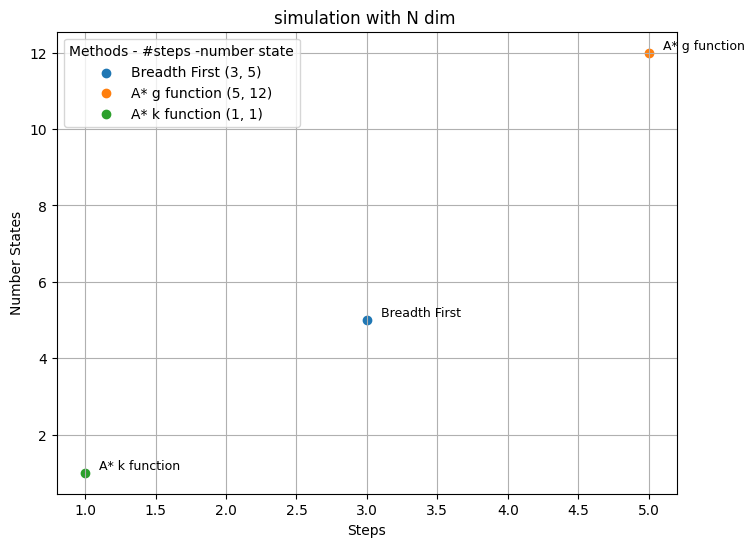

In [352]:
import matplotlib.pyplot as plt
methods = container_experiment[2]

names = [item[0] for item in methods]  # Method names
x_values = [item[1] for item in methods]  # X-axis values
y_values = [item[2] for item in methods]  # Y-axis values

# Create scatter plot
plt.figure(figsize=(8, 6))

# Plot each point individually with a label that includes the method name and coordinates
for x, y, name in zip(x_values, y_values, names):
    label = f"{name} ({x}, {y})"
    plt.scatter(x, y, label=label)  # Use the custom label for the legend

# Annotate each point with its method name
for i, name in enumerate(names):
    plt.text(x_values[i] + 0.1, y_values[i] + 0.1, name, fontsize=9)

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Number States')
plt.title('simulation with N dim ')

# Add legend
plt.legend(title='Methods - #steps -number state', loc='best')  # Add a legend with a title

# Show grid and the plot
plt.grid(True)
plt.show()

More function - garbage

In [ ]:
"""
PUZZLE_DIM = 2
action = namedtuple('Action', ['pos1', 'pos2'])
RANDOMIZE_STEPS = 100_000
state = np.array([i for i in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
goal = state
print(state)
for r in tqdm(range(RANDOMIZE_STEPS), desc='Randomizing'):
    state = do_action(state, choice(available_actions(state)))
state


PUZZLE_DIM = 3  
action = namedtuple('Action', ['pos1', 'pos2'])
RANDOMIZE_STEPS = 100_000
state = np.array([i for i in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
goal = state
print(state)
for r in tqdm(range(RANDOMIZE_STEPS), desc='Randomizing'):
    state = do_action(state, choice(available_actions(state)))

"""